# Credit card digital identification

## Project introduction
Image recognition is widely used in the financial industry. Computers can help people complete repetitive tasks, reduce manpower burden, and improve work efficiency. This project is intended to use OpenCV technology to identify credit card numbers. Because credit card numbers have a specific pattern, the identification can be achieved. The steps of the project are as follows:

0. [Import module](#title1)
1. [Define basic functions](#title2)
2. [Template preprocessing](#title3)
3. [Establish the correspondence between numbers and images](#title4)
4. [Input image preprocessing](#title5)
5. [Choose the right one Bounding Boxes](#title6)
6. [judge Bounding Boxes Number within](#title7)

## <span id="title1">Step0:Import module

In [43]:
from platform import python_version
import cv2
from imutils import contours
import numpy as np
import matplotlib.pyplot as plt

print('Python Version: ', python_version())
print('OpenCV Version: ', cv2.__version__ )
print('NumPy Version: ', np.__version__ )

Python Version:  3.8.11
OpenCV Version:  4.5.3
NumPy Version:  1.20.3


## <span id="title2">Step1:Define basic functions
+ sort_contours(cnts, method): Sort the contour cnts according to the sorting method method, and return the sorted contour and the bounding boxes corresponding to the contour
+ cv_show(name, img): Output img image, the image name is name

In [44]:
def sort_contours(cnts, method="left-to-right"):
    """
    Sort contours from left to right
    """
    reverse = False
    i = 0

    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
        
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))  # Sort from left to right

    
    return cnts, boundingBoxes

def cv_show(name,img):
    """
    display image
    """
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(name)
    plt.xticks([])
    plt.yticks([])
    plt.show()

## <span id="title3">Step2:Template preprocessing
This step is to find out the outline of the template and preprocess the digital template. The operation steps are as follows：
+ Read image
+ Convert to grayscale image
+ Convert to binary image
+ Find the outline

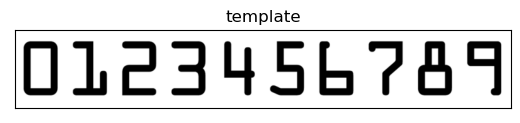

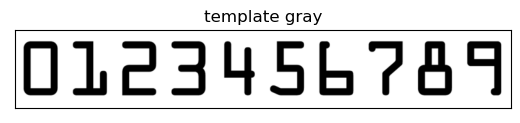

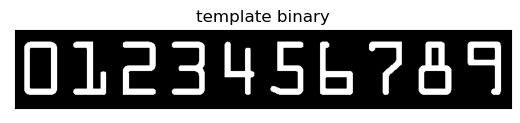

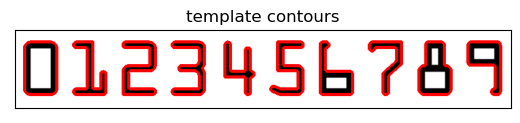

number of contours:10


In [45]:
# Read template image
template = cv2.imread(r".\images\template.png")
cv_show('template', template)

# Convert to grayscale image
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
cv_show('template gray', template_gray)

# Convert to binary image
template_binary = cv2.threshold(template_gray, 10, 255, cv2.THRESH_BINARY_INV)[1]
cv_show('template binary', template_binary)

# Find the outline
template_cnts, hierarchy = cv2.findContours(template_binary.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv_show('template contours', cv2.drawContours(template.copy(), template_cnts, -1, (0, 0, 255), 3))

print("number of contours:{}".format(len(template_cnts)))

## <span id="title4">Step3:Establish the correspondence between numbers and images
This step will cut out the square image corresponding to each number in the template, and use the digits dictionary to store all the square images. In this way, we can use these images to compare with each number on the credit card.

The square after splitting the template:


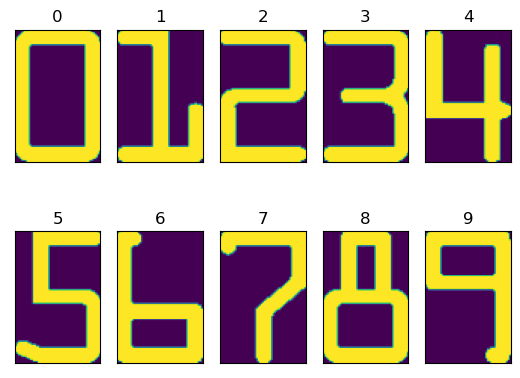

In [46]:
template_cnts = sort_contours(template_cnts, method="left-to-right")[0]  # Sort contours --> left to right

# Create a one-to-one dictionary
digits = {}
for (i, c) in enumerate(template_cnts):
    """
    Generate digits dictionary
    key: digit 
    value: digit reference
    """
    x, y, w, h = cv2.boundingRect(c)
    roi = template_binary[y:y + h, x:x + w]
    roi = cv2.resize(roi, (57, 88))
    digits[i] = roi

# display image
print("The square after splitting the template:")
for key, value in digits.items():
    plt.subplot(2, 5, key+1)
    plt.title(str(key))
    plt.imshow(value)
    plt.xticks([])
    plt.yticks([])

plt.show()

## <span id="title5">Step4:Input image preprocessing
In this step, various operations of OpenCV will be used to preprocess the input image. You can clearly observe the preprocessed image (** as shown below**) roughly marking the outline of each block on the credit card.

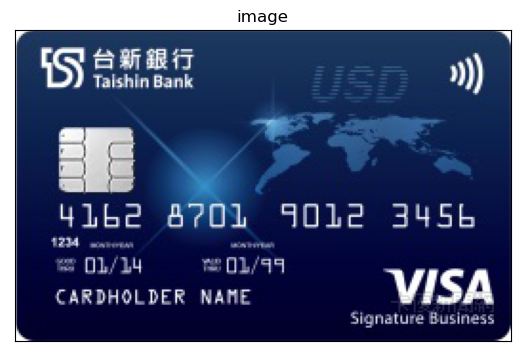

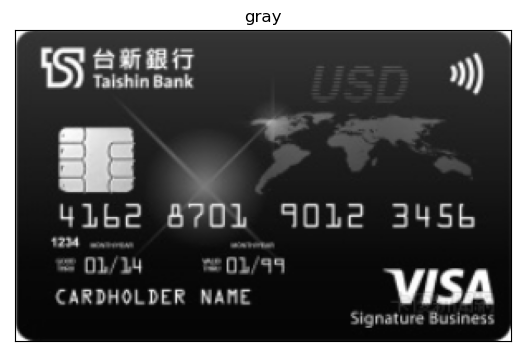

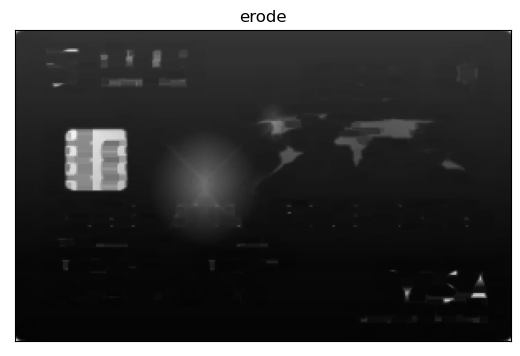

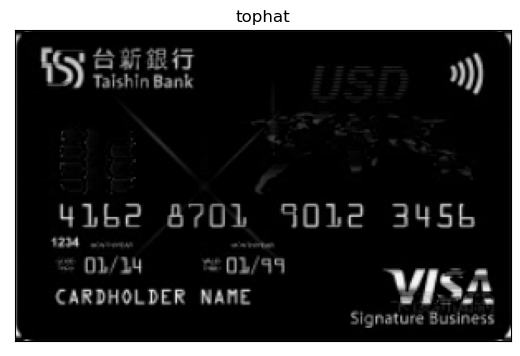

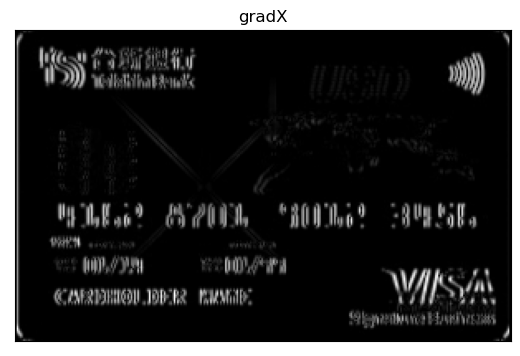

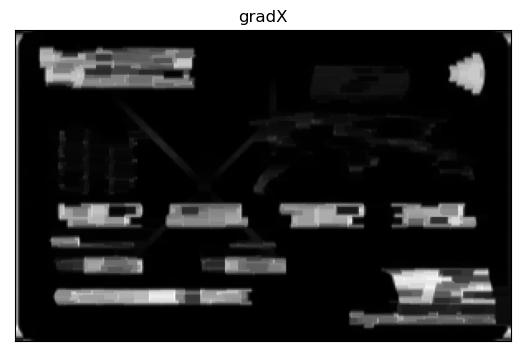

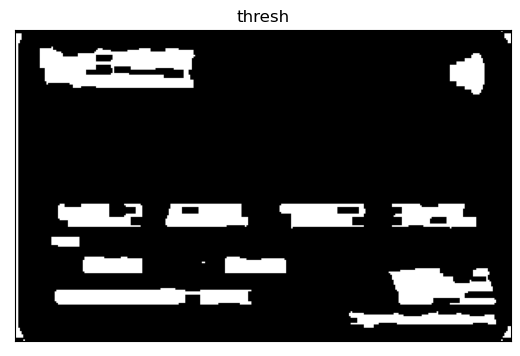

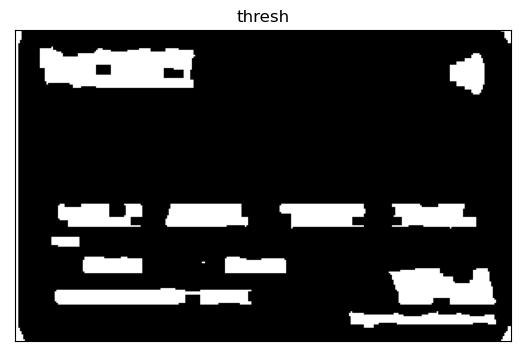

In [47]:
# Define kerenl
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

# Read image
#image = cv2.imread(r".\images\credit_card_01.png")
#image = cv2.imread(r".\images\credit_card_02.png")
#image = cv2.imread(r".\images\credit_card_03.png")
#image = cv2.imread(r".\images\credit_card_04.png")
image = cv2.imread(r".\images\credit_card_05.png")
cv_show('image',image)

# resize
h, w = image.shape[:2]
r = 300 / float(w)
dim = (300, int(h * r))
image = cv2.resize(image, dim)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv_show('gray',gray)

#  Corrosion operation
cv_show('erode', cv2.erode(gray, rectKernel))

# tophat operation
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel) 
cv_show('tophat',tophat)

# Gradient operation
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal))).astype("uint8")
cv_show('gradX',gradX)

# Closing operation: expand first, then corrode
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel) 
cv_show('gradX',gradX)

#Binarization operation, THRESH_OTS value U will automatically find the threshold
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] 
cv_show('thresh',thresh)

#Close operation
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
cv_show('thresh', thresh)

## <span id="title6">Step5:Choose the right one Bounding Boxes
In this step, some conditional expressions and the basic function sort_contours will be used to filter out the contours corresponding to the credit card account number and find the corresponding Bounding Boxes.

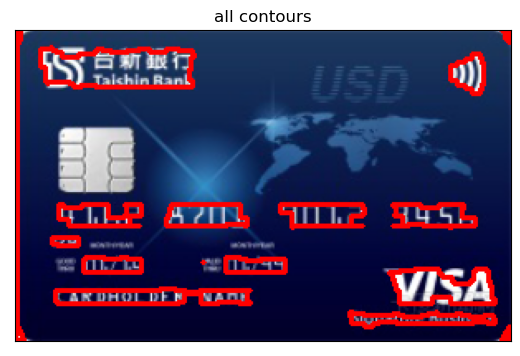

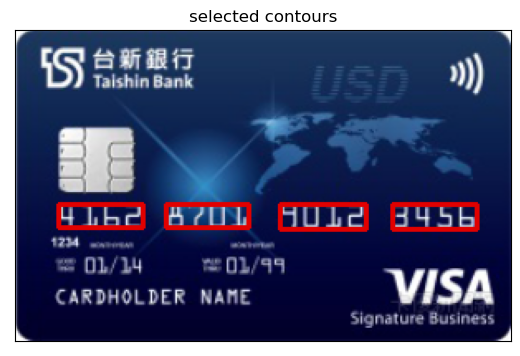

In [48]:
# Credit card outline
image_cnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv_show('all contours', cv2.drawContours(image.copy(), image_cnts, -1, (0, 0, 255), 2))
locs = []

# Find out the contour you need
for (i, c) in enumerate(image_cnts):
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    if ar > 2.5 and ar < 4.0:
        if (w > 40 and w < 55) and (h > 10 and h < 20):
            locs.append((x, y, w, h))

# Sort contours from left to right
locs = sorted(locs, key=lambda x:x[0])

image_copy = image
for loc in locs:
    cv2.rectangle(image_copy, (loc[0], loc[1]), (loc[0] + loc[2], loc[1] + loc[3]), (0,0,225), thickness=2)
cv_show('selected contours', image_copy)

## <span id="title7">Step6:Determine the number in Bounding Boxes
In the previous step, we found the Bounding Boxes of the digital block. Next, we will cut each of the Bouning Boxes so that the divided squares are each digit of the credit card account, and then use OpenCV's matchTemplate function and the digits dictionary to determine The number corresponding to each square.

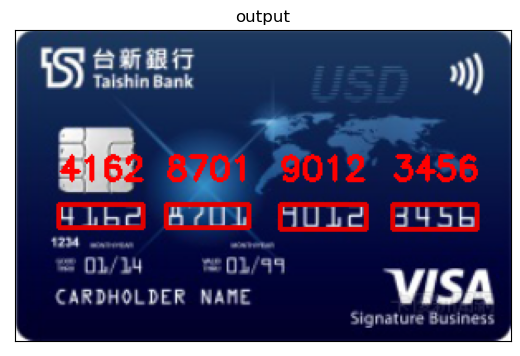

credit card number:4162 8701 9012 3456


In [49]:
# Find the number corresponding to each rectangle
output = []

for i, (gX, gY, gW, gH) in enumerate(locs):
    group_output = []
    
    # Clip each group of images
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    
    # Binarization operation
    group = cv2.threshold(group, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    # Expansion operation
    group = cv2.dilate(group, (4,4))
    
    # Calculate the contour of the group of images
    digitCnts, hierarchy = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digitCnts = contours.sort_contours(digitCnts, method = "left-to-right")[0]

    # Calculate the number corresponding to each contour
    for c in digitCnts:
        (x, y, w, h) = cv2.boundingRect(c)
        roi = group[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))
        # Calculate the score
        scores = []
        for (digit, digitROI) in digits.items():
            # Template matching
            result = cv2.matchTemplate(roi, digitROI, cv2.TM_CCOEFF)
            score = cv2.minMaxLoc(result)[1]
            scores.append(score)
        group_output.append(str(np.argmax(scores)))
    
    cv2.putText(image, "".join(group_output), (gX, gY - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)    
    output.append(group_output)

cv_show('output', image)
print("credit card number:{}".format(" ".join(["".join(alist) for alist in output])))